In [1]:
from ptycho_functions import *
from sscCdi import restoration_CAT
from sscCdi.caterete.cat_ptycho_processing import convert_probe_positions_meters_to_pixels
import numpy as np
import h5py
import cupy as cp
import time

# %matplotlib widget

def rotate_coordinate_system(angle_rad,px,py):
    px_rotated = np.cos(angle_rad) * px - np.sin(angle_rad) * py
    py_rotated = np.sin(angle_rad) * px + np.cos(angle_rad) * py
    return px_rotated, py_rotated

/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/cupy/_environment.py:436: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda110, cupy-cuda112

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [27]:
""" mPIE """
if 0: # suggested min from paper
    regularization_object, regularization_probe = 0.05, 0.5
    step_object, step_probe = 0.1, 0.2
    friction_object, friction_probe = 0.5, 0.75
    momentum_counter = 10
elif 1: # suggested max from paper
    regularization_object, regularization_probe = 0.25, 5
    step_object, step_probe = 0.5, 1
    friction_object, friction_probe = 0.9, 0.99
    momentum_counter = 10 
else: # my params
    regularization_object, regularization_probe = 0.25, 5
    step_object, step_probe = 0.5, 0.1
    friction_object, friction_probe = 0.9, 0
    momentum_counter = 100 

inputs = {}
inputs['object_pixel'] = 6.574936275422776e-08 #1.9481292667919335e-08
inputs['wavelength'] = 2.0664032897701555e-10
inputs['distance'] = 14.000035595703125
inputs['iterations'] = 200
inputs["position_rotation"] = -0.003
inputs["object_padding"] = 0
inputs['centralize_probe'] = False # not implemented 
inputs['regularization_object'] = regularization_object
inputs['regularization_probe']  = regularization_probe
inputs['step_object']= step_object
inputs['step_probe'] = step_probe
inputs['use_mPIE'] = False # friction and momentum counter only relevant if this is True
inputs['friction_object'] = friction_object
inputs['friction_probe'] = friction_probe
inputs['momentum_counter'] = momentum_counter
inputs['position_correction_beta'] = 0 # if 0, does not apply position correction
inputs["n_of_modes"] = 1

In [4]:
restored_data_path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/SS03112022_02/restored_data/0000_SS03112022_02_001.npy'
restored_data = np.load(restored_data_path)

N = 1100
restored_data = restored_data[:,N:-N,N:-N]
print(restored_data.shape)

(625, 400, 400)


In [13]:
data_path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/SS03112022_02/2023-08-09-16h25m_SS03112022_02.hdf5'
data = h5py.File(data_path,'r')

positions = data['recon/positions'][()][0][0]
positions = positions.astype(np.int32)
positions = np.roll(positions,shift=1,axis=1)

obj_guess = data['recon/initial_object'][()]
obj_guess = np.random.rand(*obj_guess.shape) + 1j*np.random.rand(*obj_guess.shape) 

probe_guess = data['recon/initial_probe'][()][0]
ft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(np.mean(restored_data,axis=0))))
probe_guess = np.sqrt(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(ft))))

print('Probe shape: ',probe_guess.shape)
print('Object shape: ',obj_guess.shape)
print('Positions shape: ',positions.shape)


Probe shape:  (400, 400)
Object shape:  (682, 682)
Positions shape:  (625, 2)


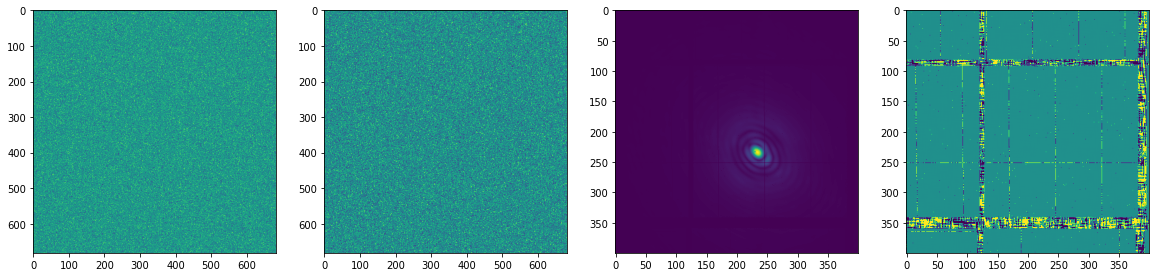

In [21]:
fig, ax = plt.subplots(1,4,figsize=(20,10))
ax[0].imshow(np.abs(obj_guess))
ax[1].imshow(np.angle(obj_guess))
ax[2].imshow(np.abs(probe_guess))
ax[3].imshow(np.angle(probe_guess))

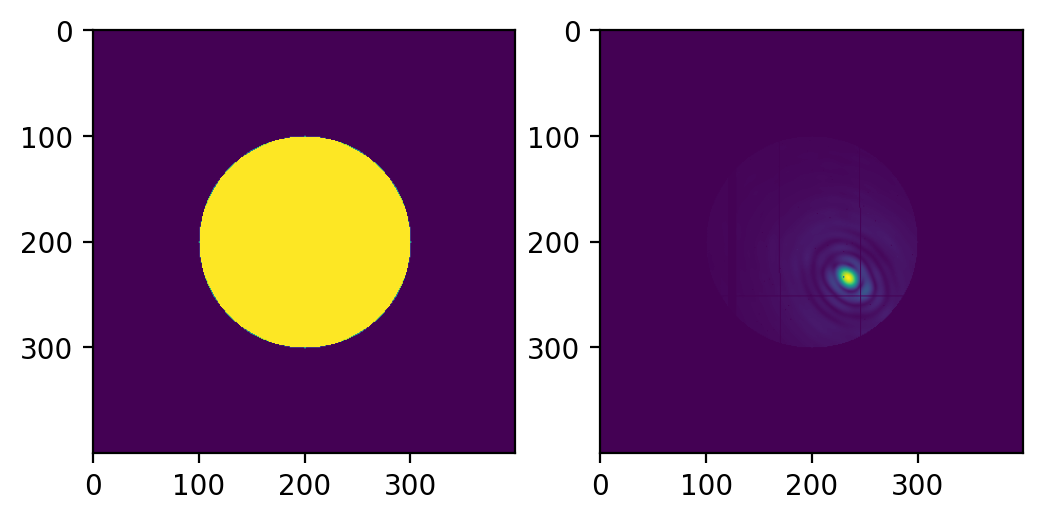

In [22]:
xx = np.linspace(0,probe_guess.shape[0]-1,probe_guess.shape[0])
xx -= xx.shape[0]//2
XX, YY = np.meshgrid(xx,xx)
R = 100
probe_support = np.where(XX**2+YY**2<=R**2,1,0)

fig, ax = plt.subplots(1,2,dpi=200)
ax[0].imshow(probe_support)
ax[1].imshow(np.abs(probe_guess*probe_support))

In [8]:
# t1 = time.time()
# PIE_obj, PIE_probe, PIE_positions, PIE_error, PIE_time, positions_story = mPIE_loop_cupy(restored_data, positions.copy(),obj_guess.copy(),probe_guess.copy(), inputs)
# print(f'elapsed: {(time.time()-t1)/60}')

In [9]:
t1 = time.time()
PIE_modes_obj, PIE_modes_probe, PIE_modes_error, _  = PIE_multiprobe_loop(restored_data, positions.copy(),obj_guess.copy(),probe_guess.copy(), inputs)
print(f'Time elapsed: {(time.time()-t1)/60} min')

Starting multiprobe PIE algorithm...
	Iteration 0/20 	Error: 1.93e+17
	Iteration 10/20 	Error: 3.44e+06
PIE algorithm ended in 41.60212832316756 seconds
Time elapsed: 0.6934721946716309 min


In [28]:
inputs['beta'] = 0.995
inputs['epsilon'] = 0.01 # small value to add to probe/object update denominator
inputs['pixel_size'] = inputs['object_pixel']

# probe_guess = PIE_modes_probe[0]

t1 = time.time()
RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_multiprobe_loop(restored_data, positions.copy(),obj_guess.copy(),probe_guess.copy(),inputs,probe_support=probe_support)
print(f'Time elapsed: {(time.time()-t1)/60} min')

	Iteration 0/200 	Error: 1.39e+15
	Iteration 10/200 	Error: 1.95e+12
	Iteration 20/200 	Error: 3.98e+12
	Iteration 30/200 	Error: 2.49e+12
	Iteration 40/200 	Error: 1.54e+12
	Iteration 50/200 	Error: 9.62e+11
	Iteration 60/200 	Error: 5.54e+11
	Iteration 70/200 	Error: 1.02e+11
	Iteration 80/200 	Error: 1.90e+10
	Iteration 90/200 	Error: 2.78e+10
	Iteration 100/200 	Error: 3.29e+10
	Iteration 110/200 	Error: 3.56e+10
	Iteration 120/200 	Error: 1.85e+10
	Iteration 130/200 	Error: 1.04e+10
	Iteration 140/200 	Error: 4.86e+09
	Iteration 150/200 	Error: 6.11e+09
	Iteration 160/200 	Error: 6.39e+09
	Iteration 170/200 	Error: 6.05e+09
	Iteration 180/200 	Error: 1.38e+10
	Iteration 190/200 	Error: 1.21e+10
RAAR algorithm ended in 490.89944155700505 seconds
Time elapsed: 8.181776384512583 min


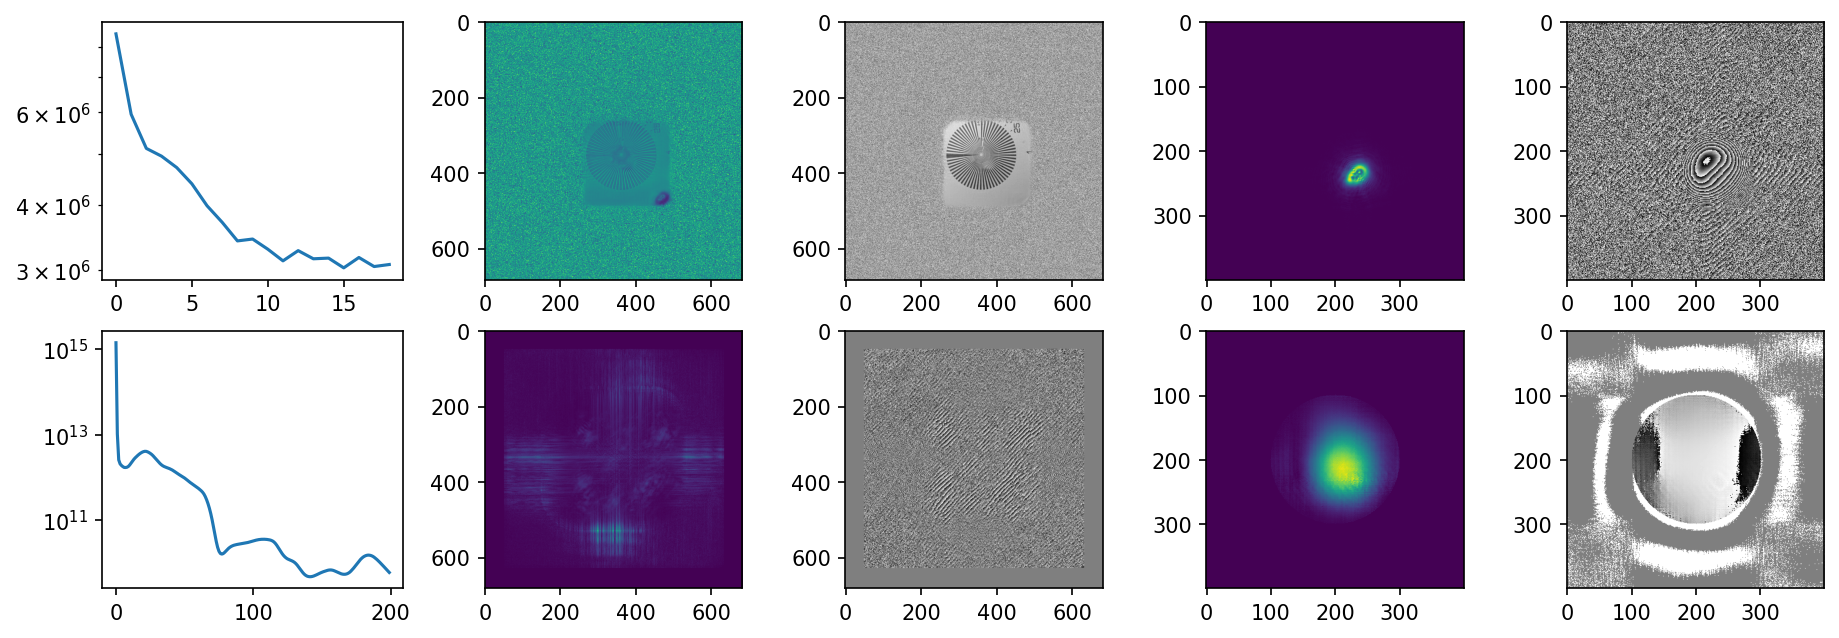

In [29]:
# PIE_obj.shape, PIE_probe.shape

colormap = 'viridis'
colormap2 = 'gray'   

figure, ax = plt.subplots(2,5,dpi=150,figsize=(15,5))

ax[0,0].plot(PIE_modes_error[1::])
ax[0,1].imshow(np.abs(PIE_modes_obj[0]),cmap=colormap)
ax[0,2].imshow(np.angle(PIE_modes_obj[0]),cmap=colormap2)
ax[0,3].imshow(np.abs(PIE_modes_probe[0]),cmap=colormap)
ax[0,4].imshow(np.angle(PIE_modes_probe[0]),cmap=colormap2)

# ax[1,0].plot(PIE_error[1::])
# ax[1,1].imshow(np.abs(PIE_obj),cmap=colormap)
# ax[1,2].imshow(np.angle(PIE_obj),cmap=colormap2)
# ax[1,3].imshow(np.abs(PIE_probe),cmap=colormap)
# ax[1,4].imshow(np.angle(PIE_probe),cmap=colormap2)

ax[1,0].plot(RAAR_error)
ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap2)
ax[1,3].imshow(np.abs(RAAR_probe[0]),cmap=colormap)
ax[1,4].imshow(np.angle(RAAR_probe[0]),cmap=colormap2)

ax[0,0].set_yscale('log')
ax[1,0].set_yscale('log')